In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from urllib.parse import urlparse
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from unicodedata import digit
from sklearn.preprocessing import StandardScaler

In [193]:
df1 = pd.read_csv("malicious_phish.csv")  #malicious_phish.csv #balanced_urls.csv
replacements = {'benign':0,"phishing":1,"defacement":1,"malware":1}
df1['type'] = df1['type'].replace(replacements)
df1.rename(columns={'type': 'labels'}, inplace=True)


df2 = pd.read_csv("balanced_urls.csv")
df2.drop('label', axis=1, inplace=True)
df2.rename(columns={'result': 'labels'}, inplace=True)

In [194]:
def lenght_url(url):
  return len(url)

In [195]:
def length_host(url):
  parsed = urlparse(url)
  
  if not parsed.netloc:
    if "www" == parsed.path[0:3]:
      stops = parsed.path[4:]
      return stops.find("/")
    else:
      stops = parsed.path.find("/")
      return stops
  else:
    if "www" == parsed.netloc[0:3]:
      stops = parsed.netloc[4:]
      return len(stops)
    else:
      return len(parsed.netloc)

In [196]:
def length_path(url):
    parsed = urlparse(url)
    if not parsed.netloc:
        path = parsed.path.split("/")
        path.pop(0)
        counter = 0
        for i in path:
          counter+=len(i)
        return counter + len(path)
    else:
        return len(parsed.path)

In [197]:
def length_first_dir(url):
    parsed = urlparse(url)
    if not parsed.netloc:
        fist_dir = parsed.path.split("/")
        if len(fist_dir) != 1:
          return len(fist_dir[1])
        else:
          return 0
    else:
        if parsed.path == "":
          return 0
        else:
          fist_dir = parsed.path[1:].split("/")
          return len(fist_dir[0])

In [198]:
def length_top_dom(url):
  parsed = urlparse(url)
  if not parsed.netloc:
    stops = parsed.path.split("/")[0]
    return len(stops.split(".")[-1])
  else:
    return len(parsed.netloc.split(".")[-1])

In [199]:
def is_url_shortened(url):
    regex = 'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|' 'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' 'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' 'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|' 'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|' 'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' 'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' 'tr\.im|link\.zip\.net'
    short = re.search(regex,url)
    if short:
      return 1
    else:
      return 0

In [200]:
def has_ip(url):
    ips = r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'
    boolean = re.search(ips, url)
    if boolean:
        return 1
    else:
        return 0

In [201]:
def count_feat(url):
  feat = {"dash":0,"at":0,"questions":0,"percentage":0,"fullstop":0,"equal":0,"http":0,"https":0,"www":0,"digits":0,"letters":0,"directories":0}

  for i in url:
    if i=="-" : feat["dash"] += 1
    elif i=="@" : feat["at"] += 1
    elif i=="?" : feat["questions"] += 1
    elif i=="%" : feat["percentage"] += 1
    elif i=="." : feat["fullstop"] += 1
    elif i=="=" : feat["equal"] += 1 
    elif i.isalpha() : feat['letters'] +=1
    elif i in '1234567890' : feat['digits'] +=1
  k=0
  if "http:/" in url:
    feat["http"] += 1
    k=1
  if "https:/" in url:
    feat["https"] += 1
    k=1
  if "www." in url:
    feat["www"] += 1
  dir = url.split('/')
  if '' in dir:dir.remove('')
  feat['directories']=len(dir)-k
  return feat

In [202]:
def generate_set(Z):
  size = len(Z)
  x = np.zeros((size,19))
  for i in tqdm(range(size)):
    url = Z["url"][i]
    feat = count_feat(url)
    x[i][0],x[i][1],x[i][2],x[i][3] = lenght_url(url),length_host(url),length_path(url),length_first_dir(url)
    x[i][4],x[i][5],x[i][6],x[i][7] = length_top_dom(url),has_ip(url),is_url_shortened(url),feat["directories"]
    x[i][8],x[i][9],x[i][10],x[i][11] = feat["dash"],feat["at"],feat["questions"],feat["percentage"]
    x[i][12],x[i][13],x[i][14],x[i][15] =feat["fullstop"],feat["equal"],feat["http"],feat["https"]
    x[i][16],x[i][17],x[i][18] =feat["www"],feat["digits"],feat["letters"]
  return x

In [203]:
x1 = generate_set(df1)
x2 = generate_set(df2)

df = pd.concat([df1, df2], ignore_index=True)
y = df["labels"].to_numpy()

x = np.vstack((x1, x2))


analysis = np.hstack((x, y[:, np.newaxis]))
column_names = ['Url ength', 'Host length', 'Path length',"First directory length","Top domain length","IP","Shortened","#Directories","#Dashes","#@","#?","#%","#.","#=","Has http","Has https","Has www","#Digits","#Letters","Labels"]
df_analysis = pd.DataFrame(analysis, columns=column_names)

100%|██████████| 632508/632508 [00:21<00:00, 29585.87it/s]


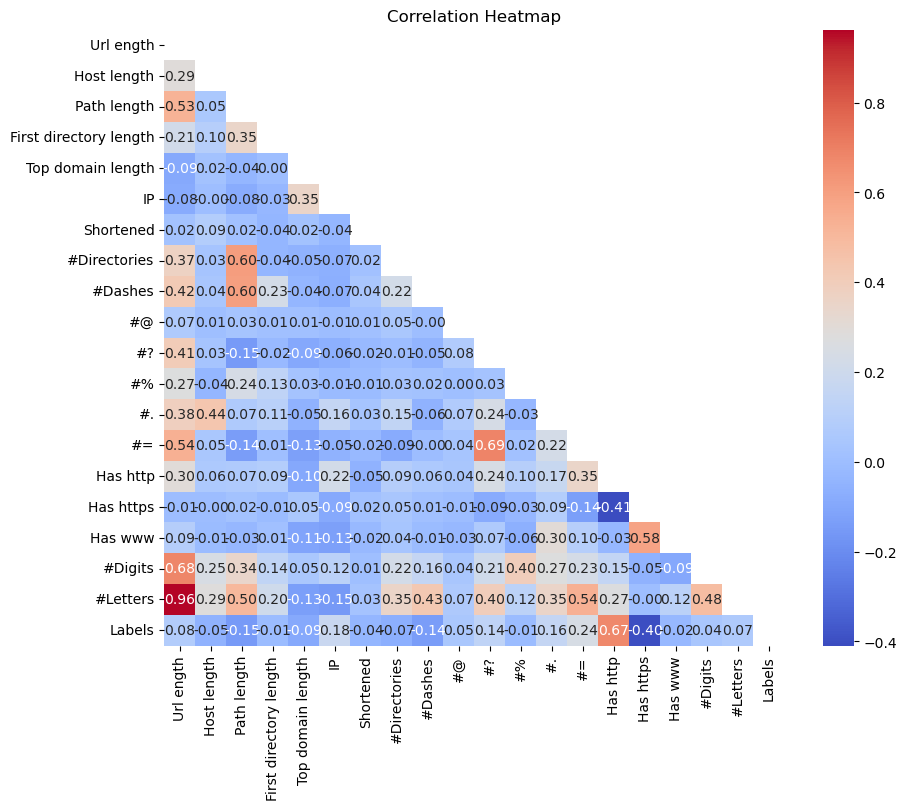

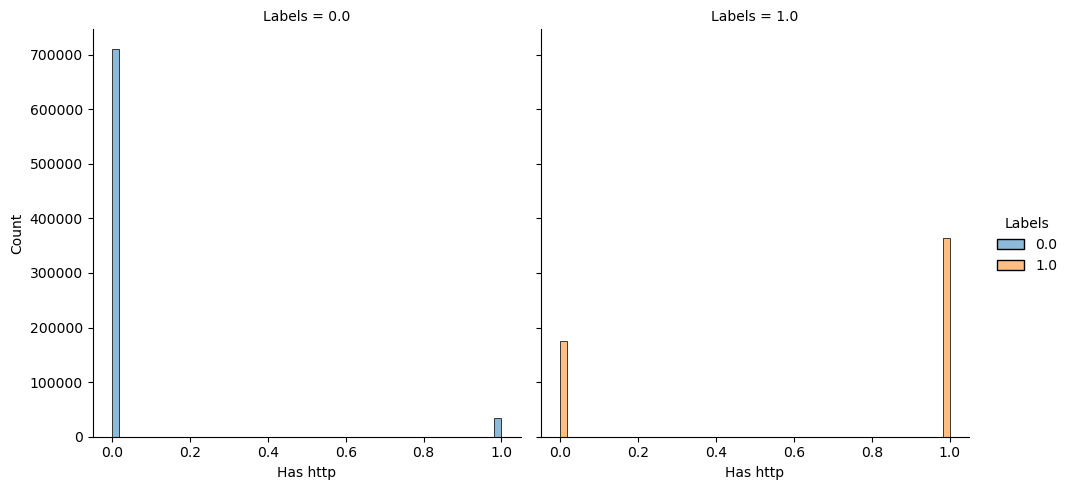

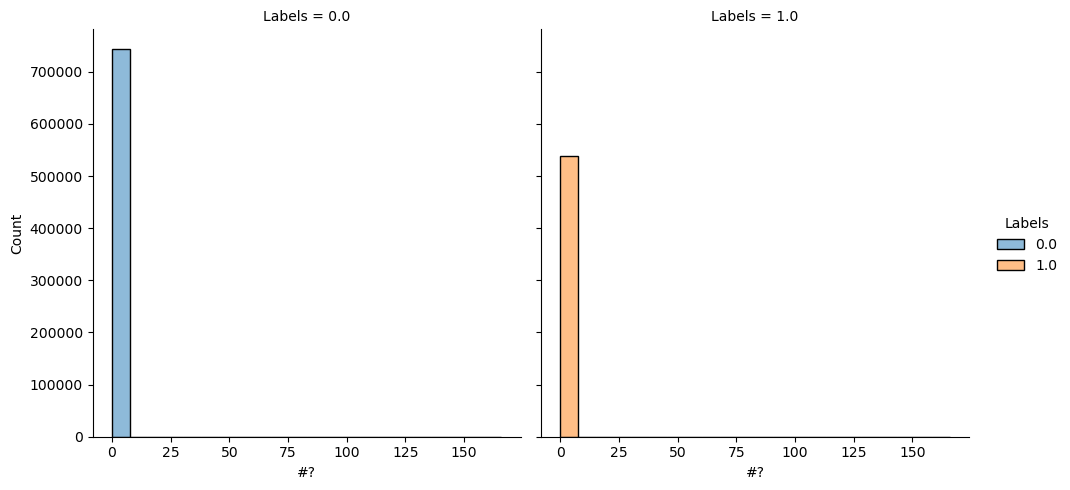

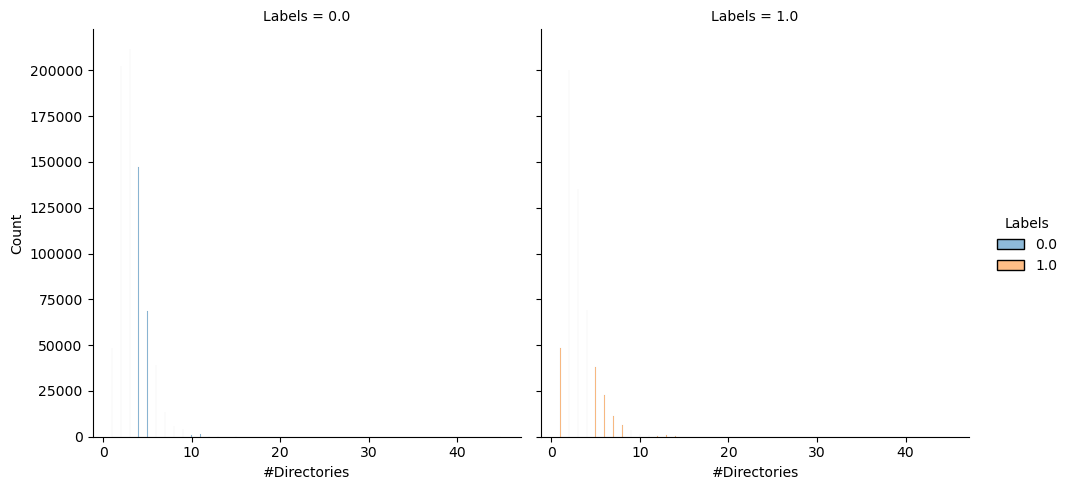

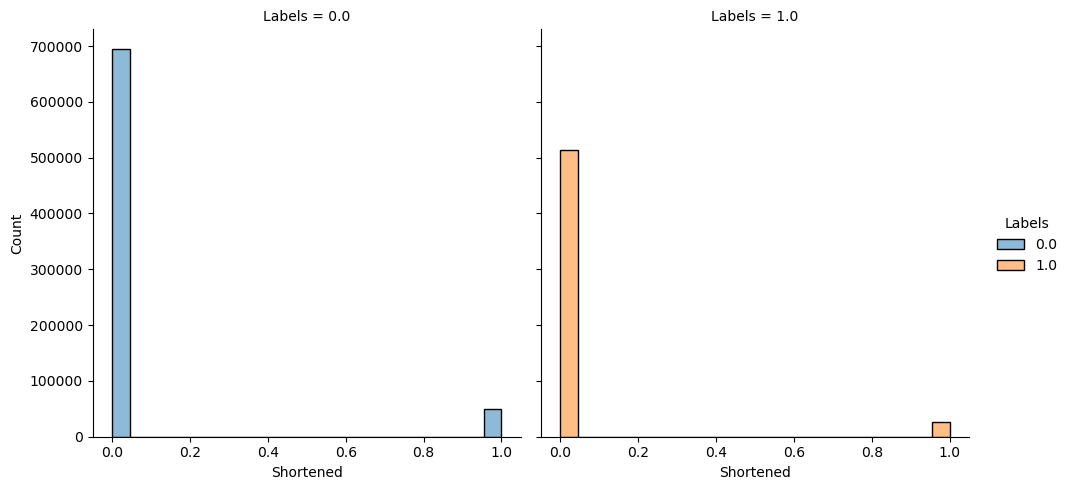

In [212]:
correlation = df_analysis.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax)

plt.title("Correlation Heatmap")

plt.xticks(rotation=90)

plt.show()

import pandas.plotting as pd_plot

sns.displot(data=df_analysis, x="Has http", hue="Labels", col="Labels")
sns.displot(data=df_analysis, x="#?", hue="Labels", col="Labels")
sns.displot(data=df_analysis, x="#Directories", hue="Labels", col="Labels")
sns.displot(data=df_analysis, x="Shortened", hue="Labels", col="Labels")

In [205]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3, random_state=42)

log_model = LogisticRegression(solver='liblinear')
log_model.fit(x_train,y_train)
log_predictions = log_model.predict(x_test)
print(accuracy_score(y_test,log_predictions))

0.9014990151236938
